|Name|SNR|ANR|
|----|---|----|
|E.A. Teräsaho|1271529|u206957|
|W. Oude Lansink|2000959|u809574|

In [1]:
NAME = "eaterasaho"
COLLABORATORS = "Wisseol"

For this problem set, we'll be using the Jupyter notebook

![](jupyter.png)

## Table of Contents

1. [Research question](#first-bullet)
2. [Motivation](#second-bullet)
3. [Method](#third-bullet)
4. [Dependencies](#fourth-bullet)
5. [Data](#fifth-bullet)
6. [Preview of the answers](#sixth-bullet)
7. [Main assumptions](#seventh-bullet)
8. [Python code](#eighth-bullet)
9. [Robustness analysis](#ninth-bullet)
10. [Discussion and conclusion](#tenth-bullet)

# Research question <a class="anchor" id="first-bullet"></a>

Does the price volatility and variance of trading volume of a stock influence the goodness of fit and the mean squared error of an LSTM model predicting stock prices?

$H_{0p_1}$: There is no effect of price volatility on the goodness of fit

$H_{0v_1}$: There is no effect of variance of trading volume on the goodness of fit

$H_{0p_2}$: There is no effect of price volatility on the mean squared error

$H_{0v_2}$: There is no effect of variance of trading volume of a stock on the mean squared error

$H_{1p_1}$: There is an effect of price volatility on the goodness of fit

$H_{1p_2}$: There is an effect of price volatility on the mean squared error

$H_{1v_1}$: There is an effect of variance of trading volume on the goodness of fit

$H_{1v_2}$: There is an effect of variance of trading volume on the mean squared error

# Motivation <a class="anchor" id="second-bullet"></a>

**“If computing power and data generation keep growing at the current rate, then machine learning could be involved in 99 percent of investment management in 25 years. It will become ubiquitous in our lives. I don’t think that machine learning is the answer to everything we do. It just can make us better at a lot of things that we do.”**  - [Luke Ellis, CEO of Man Group Plc](https://www.fa-mag.com/news/hedge-funds-face-new-era-as-ai-becomes-a-master-of-the-universe-36047.html?print)


Machine learning (ML) techniques are gaining popularity among equity traders, due to the capability of ML models to analyze amounts of data from various sources. These techniques involve predicting future company financials or stock prices, by inputting these variables to an ML model. Algorithm traders, who utilize a ML model predicting stock prices, are reliant on the models' ability to predict in their goal of turning a profit. Therefore, we believe it is important to investigate various factors which might alter the reliability of a given algorithm. These factors might be the choice of data source, data types or factors inherent to the stock price itself, like its volatility or its changes in trading volume. We have decided to limit ourself to only one data source and variable, in order to assess the relationship of the stocks' price volatility and variance of daily trading volume, and the goodness of fit of an ML model predicting its price.

# Method <a class="anchor" id="third-bullet"></a>

1. We use data of stocks daily adjusted closing prices and their daily trading volume
2. We clean the data by removing missing values and excluding outliers from our stratified sample.
3. Outliers are defined as those stocks in which their values of the variables of interest lie outside $\pm1.5*$interquartile range
4. The stratification is done by grouping the stocks into 4 stratas by the values of variables of interest.
5. A sample of 50 stocks from a population of 420 is selected for analysis.
6. The price data of stocks are preprocessed for the ML model by normalizing the values and formatting them to fit the model.
7. We build an Long Short-Term Memory (LSTM) ML model to predict stock prices and tune its parameters using package 'talos'. LSTM models are specific recurrent neural netowrk (RNN) models. An RNN allows past information to persist, which is important in predicting future stock prices, as underlying patterns in the stock market may persist and affect the price for an extended period. However, a traditional RNN is limited in its ability to learn the gap(s) between relevant information and the predicted point, which is why we turn our gaze to LSTM models. They are more capable of learning these long-term dependencies as remembering information for long periods of time is more of a default behavior for them.
8. The 'talos' scan is ran twice, results of the first round are used to narrow down the selection of parameters for the second round.
9. The best performing parameters are used in fitting the model with price data of all stocks.
10. The models are used to predict the values of the testing data.
11. We obtain the measures of $R^2$ and MSE from comparing the predictions to the actual values.
12. Using the measures, a correlation analysis is performed.

# Dependencies <a class="anchor" id="fourth-bullet"></a>

Before downloading the data, we import the dependences necessary to run this notebook and set the pyplot style to 'ggplot'.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Importing dependencies
import os
import pandas_datareader as web
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import datetime as dt
import time
import tensorflow
from tensorflow import set_random_seed
set_random_seed(2)
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import talos

Using TensorFlow backend.


# Data <a class="anchor" id="fifth-bullet"></a>

The data used in this notebook, consisting the adjusted close price and trading volume of stocks currently in the S&P 500 is downloaded from [Yahoo! Finance](https://finance.yahoo.com/). We have decided on the range of data to be from 1 Jan 2010 to 31 Dec 2019 to avoid the effects of the recent U.S. financial crisis on our data. An outside event, namely the subprime mortgatge crisis, acted as a catalyst to the financial crisis. As it is not visible in our data, our ML model might make predictions based on the effects the crisis had on the stock prices, while not actually learning the cause to such effects.

The dataset is too big to upload into github, but running the following cell will download it.

In [4]:
if os.path.isfile('stocks.csv'): # This row checks if the data is already in .csv format in the repository
    multpl_stocks = pd.read_csv('stocks.csv', header = [0,1], parse_dates=[0], index_col=[0])
    print('Data fetched from repository')

else: # If the data is not in the repository, it will be downloaded
    # Next rows scrape the ticker symbols from a wikipedia page listing all S&P 500 companies and saves them in a list 
    table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    df = table[0]
    df.to_csv('S&P500-Info.csv')
    df.to_csv("S&P500-Symbols.csv", columns=['Symbol'])
    ticker = df['Symbol']
    tickers = ticker.values.tolist()
    tickers = [w.replace('.', '-') for w in tickers]
    # Next row scrapes the data from Yahoo! Finance, using the list of tickers
    multpl_stocks = web.get_data_yahoo(tickers, start = "2010-01-01", end = "2019-12-31")
    multpl_stocks = multpl_stocks[['Adj Close', 'Volume']] # Picking only the attributes of data we need
    multpl_stocks.dropna(axis=1, how='any', inplace=True) # Dropping columns with missing data
    multpl_stocks.to_csv(r'stocks.csv')
    print('Data dowloaded from Yahoo Finance and saved to repository')

multpl_stocks.head()

Data fetched from repository


Attributes  Adj Close                                                          \
Symbols           MMM        ABT  ABMD        ACN       ATVI       ADBE   AMD   
Date                                                                            
2010-01-04  62.895260  18.152946  8.74  33.719078  10.126624  37.090000  9.70   
2010-01-05  62.501301  18.006285  8.53  33.927479  10.144546  37.700001  9.71   
2010-01-06  63.387695  18.106277  8.40  34.288147  10.090778  37.619999  9.57   
2010-01-07  63.433144  18.256275  8.40  34.256084   9.848815  36.889999  9.47   
2010-01-08  63.880119  18.349606  8.23  34.119835   9.768159  36.689999  9.43   

Attributes                                   ...      Volume            \
Symbols           AAP        AES        AFL  ...         WMB      WLTW   
Date                                         ...                         
2010-01-04  39.223591  10.669841  15.187072  ...   7020200.0  348000.0   
2010-01-05  38.990475  10.560567  15.627653  ...   7415400.0  339500.0   
2010-01-06  39.330433  10.451293  15.764930  ...  12157100.0  585000.0   
2010-01-07  39.320717  10.459099  15.934138  ...   6181300.0  328600.0   
2010-01-08  39.476143  10.755699  15.774510  ...   4703700.0  279300.0   

Attributes                                                                   \
Symbols          WYNN        XEL        XRX       XLNX        YUM      ZBRA   
Date                                                                          
2010-01-04  4741400.0  2670400.0  5112800.0  2824700.0  2962200.0  168800.0   
2010-01-05  5644300.0  4321400.0  3255800.0  3469700.0  3298700.0  168800.0   
2010-01-06  2738800.0  2164500.0  2634300.0  6329200.0  4178900.0  385300.0   
2010-01-07  2388500.0  3041700.0  4508500.0  9252700.0  2452400.0  183600.0   
2010-01-08  1539800.0  1599100.0  2460100.0  5005800.0  3772300.0  266500.0   

Attributes                         
Symbols           ZBH        ZION  
Date                               
2010-01-04   782400.0   3974600.0  
2010-01-05  1718100.0   5605500.0  
2010-01-06  1277300.0  12615200.0  
2010-01-07  1683500.0  24716800.0  
2010-01-08  2149500.0   6903000.0  

[5 rows x 900 columns]

# Preview of the answers <a class="anchor" id="sixth-bullet"></a>

We found that the correlation of volatility and standard deviation of the percent change in trading volume with the $R^2$ of the ML model predictions and their mean squared errors are very weak. This finding is supported by the low explanatory power of these variables of interest on the outcome variables.

We conclude, that we do not find evidence for the relationship between the variables of interest and the outcome variable.

# Main assumptions <a class="anchor" id="seventh-bullet"></a>

As our ML model only uses past price as the input variable, we make the assumption that future prices of stocks are only influenced by past prices.

We also make the assumption that the ML model parameters tuned for one stock, are also optimal for all stocks in our sample.

# Python code <a class="anchor" id="eighth-bullet"></a>

## Random stratified sampling <a class="anchor" id="eigtha-bullet"></a>

From our data, we select a sample of stocks, as running an LSTM model for all is very timeconsuming and our CPU speed is limited.

First, we calculate the price volatility (standard deviation of daily returns) and standard deviation of the relative change in trading volume of all the stocks.

Second, we will drop the outliers of the data. We do this by defining the interquartile range for both variables defined above and multiplying this with $\pm 1.5$ to obtain the higher and lower bounds of values. The values between the bounds were kept and and outliers are dropped from the sample.

Third, we stratify the sample. We assign two ranks to each stock for the price volatility and standard deviation of the relative change of trading volume. These ranks are used to stratify the stocks. We now have 8 stratas (4 for each variable). Subsequently, we randomly select 50 stocks in such a way that from each strata 12-13 stocks are randomly selected. With this method we obtain a balanced sample of stocks.

In [5]:
# Calculating volatility and std of relative change in trading volume of stocks
daily_returns = multpl_stocks['Adj Close'].pct_change()

p_vol = daily_returns.std().rename('p_vol')
v_std = multpl_stocks['Volume'].pct_change().std().rename('v_std')

p_vol = p_vol.to_frame()
v_std = v_std.to_frame()

w_outliers = pd.merge(p_vol, v_std, on='Symbols')
w_outliers.dropna(how='any', inplace=True) # Dropping rows with missing values
w_outliers

,p_vol,v_std
Symbols,,
MMM,0.012182,0.416057
ABT,0.011773,0.472934
ACN,0.013371,0.474176
ATVI,0.018950,0.679129
ADBE,0.017677,0.477445
...,...,...
XLNX,0.017865,0.571993
YUM,0.014083,0.515664
ZBRA,0.021024,0.762689


In [6]:
# Defining the IQR and dropping outliers
q1_vol, q3_vol= np.percentile(sorted(w_outliers['p_vol']),[25,75])
iqr_vol = q3_vol-q1_vol
lower_bound_vol = q1_vol - (1.5*iqr_vol)
upper_bound_vol = q3_vol + (1.5*iqr_vol)
volatility = w_outliers['p_vol'][w_outliers['p_vol'].between(lower_bound_vol, upper_bound_vol, inclusive=False)].rename('volatility')

q1_volu, q3_volu= np.percentile(sorted(w_outliers['v_std']),[25,75])
iqr_volu = q3_volu-q1_volu
lower_bound_volu = q1_volu - (1.5*iqr_volu)
upper_bound_volu = q3_volu + (1.5*iqr_volu)
volume_std = w_outliers['v_std'][w_outliers['v_std'].between(lower_bound_volu, upper_bound_volu, inclusive=False)].rename('volume_std')

volatility = volatility.to_frame()
volume_std = volume_std.to_frame()

n_outliers = pd.merge(volatility, volume_std, on='Symbols')

In [7]:
# Descriptive statistics with and without outliers
pd.concat([w_outliers, n_outliers[['volatility','volume_std']]], axis=1).describe()

,p_vol,v_std,volatility,volume_std
count,439.000000,439.000000,420.000000,420.000000
mean,0.016402,0.567818,0.016148,0.547826
std,0.004214,0.182760,0.003874,0.111944
min,0.008950,0.338717,0.008950,0.338717
25%,0.013132,0.463056,0.013095,0.460775
50%,0.015773,0.528051,0.015652,0.523067
75%,0.019097,0.631624,0.018738,0.613665
max,0.032808,3.069562,0.026512,0.866401


From above, we notice that dropping outliers resulted in dropping 19 stocks. Those stocks were dropped from the higher end of the range. This implies that the values are slightly skewed to the right and most points lie at at a low value close to the median.

In [8]:
# Assigning the ranks
n_outliers['price_rank'] = n_outliers.volatility.rank()
n_outliers['volume_rank'] = n_outliers.volume_std.rank()

# Stratifying on ranks
n_outliers.loc[n_outliers['price_rank'] <= 420, 'price_group'] = 3
n_outliers.loc[n_outliers['price_rank'] <= 315, 'price_group'] = 2
n_outliers.loc[n_outliers['price_rank'] <= 210, 'price_group'] = 1
n_outliers.loc[n_outliers['price_rank'] <= 105, 'price_group'] = 0

n_outliers.loc[n_outliers['volume_rank'] <= 420, 'volume_group'] = 3
n_outliers.loc[n_outliers['volume_rank'] <= 315, 'volume_group'] = 2
n_outliers.loc[n_outliers['volume_rank'] <= 210, 'volume_group'] = 1
n_outliers.loc[n_outliers['volume_rank'] <= 105, 'volume_group'] = 0

# Random stratified sampling from population
drop_count = n_outliers.groupby(['price_group', 'volume_group'])['price_group'].count()

stratified_sample = list(map(lambda a : n_outliers[
    (n_outliers['price_group'] == drop_count.index[a][0]) &
    (n_outliers['volume_group'] == drop_count.index[a][1])].sample(frac=0.12, random_state = 121), range(len(drop_count))))

stratified_sample = pd.concat(stratified_sample)
stratified_sample.head()

,volatility,volume_std,price_rank,volume_rank,price_group,volume_group
Symbols,,,,,,
PSA,0.012409,0.402029,76.0,15.0,0.0,0.0
TRV,0.011224,0.414082,41.0,27.0,0.0,0.0
MMC,0.011137,0.435838,36.0,68.0,0.0,0.0
LMT,0.011140,0.459343,38.0,100.0,0.0,0.0
DTE,0.010090,0.476314,10.0,129.0,0.0,1.0


In [9]:
# Descriptive statistics and comparing to the population
pd.concat([n_outliers[['volatility','volume_std']], stratified_sample[['volatility','volume_std']]], axis=1).describe()

,volatility,volume_std,volatility,volume_std
count,420.000000,420.000000,50.000000,50.000000
mean,0.016148,0.547826,0.016094,0.544501
std,0.003874,0.111944,0.003797,0.117244
min,0.008950,0.338717,0.010090,0.366782
25%,0.013095,0.460775,0.013348,0.459708
50%,0.015652,0.523067,0.015652,0.525103
75%,0.018738,0.613665,0.018292,0.623387
max,0.026512,0.866401,0.025023,0.866401


As seen above, the randomization seems successful as the sample mean and standard deviation of both variables are close to the population mean and standard deviation of both variables.

In [10]:
# Defining the sample DataFrame for further use
adj_close = multpl_stocks['Adj Close'][stratified_sample.index]

## Data preprocessing for model

First, the data is split into train, validation and test data.

Second, all prices are scaled to 0 for the lowest and 1 for the highest, with each stock having its own scale. Normalizing the data in this manner increases the efficiency of our model, as absolute values of variance and prices are lower. This means that the model will learn to predict faster. In order to inverse transfrom our predictions to actual values, we create another dictionary for collecting the scaler.

Third, we reshape our data, such that each outcome value is predicted on 60 values prior to it. We chose 60, due to the volatile nature of stock prices. With 60 steps, the model is able to capture longer-lasting trends in the price path, while also allowing for more rapid changes.

In [11]:
# As we are predicting multiple stocks, we are going to work with for-loops.
# Therefore, we need to define a list of the stock symbols.
ticlist = list(adj_close.columns)

In [12]:
# Splitting the data
def split(dataframe, border1, border2):
    return dataframe.loc[:border1], dataframe.loc[border1:border2], dataframe.loc[border2:]

df_new = {}
for i in ticlist:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Val"], df_new[i]["Test"] = split(adj_close[i], "1-1-2016", "1-1-2018")

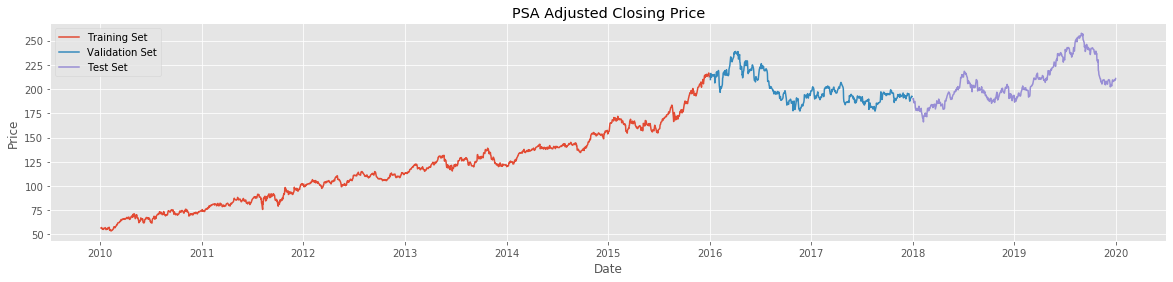

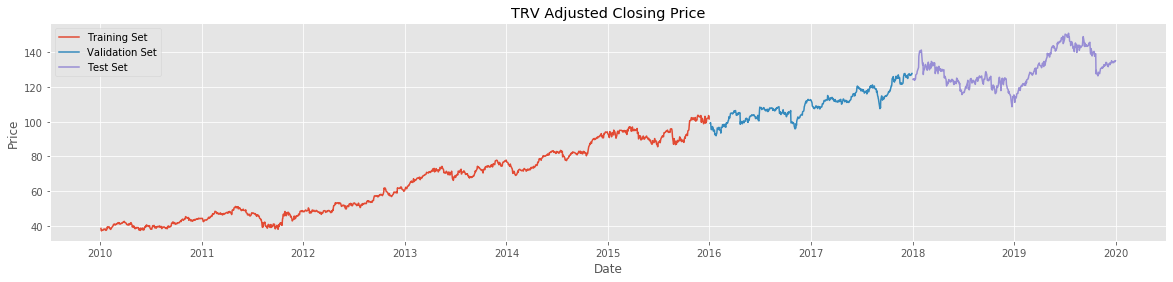

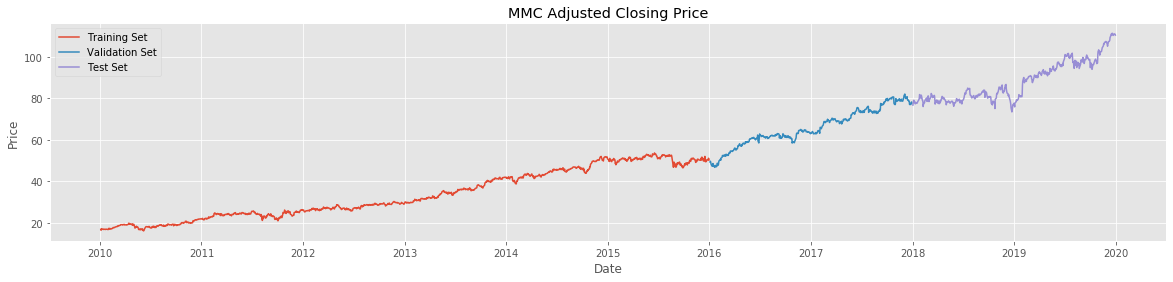

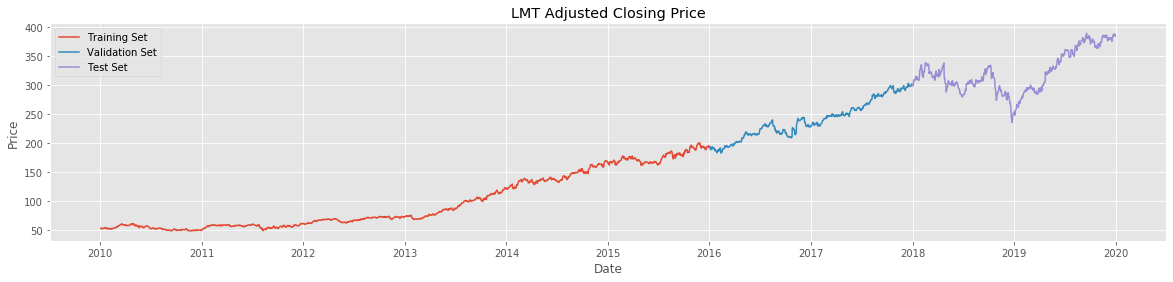

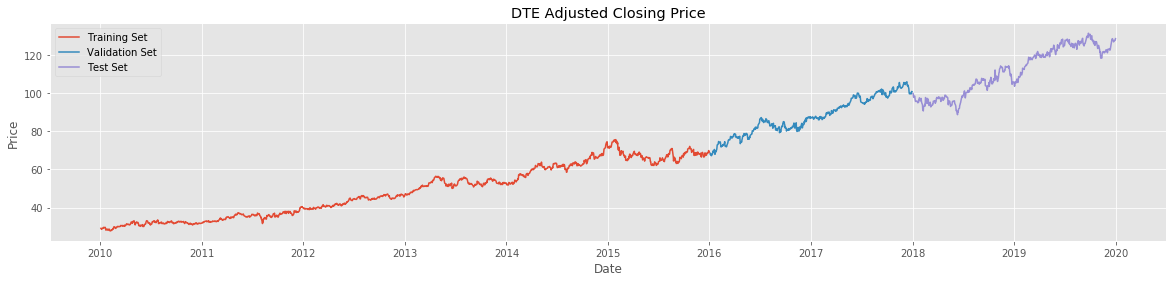

In [13]:
# Visualizing the splits with 5 stocks
for i in ticlist[:5]:
    plt.figure(figsize=(20,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Val"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Validation Set", "Test Set"], loc='upper left')
    plt.title(i + " Adjusted Closing Price")

In [14]:
# Scaling the datasets and creating dictionaries
transform_train = {}
transform_val = {}
transform_test = {}
scaler = {}

for num, i in enumerate(ticlist):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"])
    a1 = np.array(df_new[i]["Val"])
    a2 = np.array(df_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    a2 = a2.reshape(a2.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_val[i] = sc.fit_transform(a1)
    transform_test[i] = sc.fit_transform(a2)
    scaler[i] = sc
    
    
del a0
del a1
del a2

In [15]:
# Applying the timestep of 60 and reshaping the datasets accordingly
trainset = {}
valset = {}
testset = {}
for j in ticlist:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(60,1510):
        X_train.append(transform_train[j][i-60:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    valset[j] = {}
    X_val = []
    y_val = []    
    for i in range(60, 503):
        X_val.append(transform_val[j][i-60:i,0])
        y_val.append(transform_val[j][i,0])
    X_val, y_val = np.array(X_val), np.array(y_val)
    valset[j]["X"] = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    valset[j]["y"] = y_val
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(60, 503):
        X_test.append(transform_test[j][i-60:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [16]:
# Visualizing the shapes of the datasets in a DataFrame and checking that they have the same shape
arr_buff = []
for i in ticlist:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_val"] = valset[i]["X"].shape
    buff["y_val"] = valset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=ticlist)

,X_train,y_train,X_val,y_val,X_test,y_test
PSA,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"
TRV,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"
MMC,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"
LMT,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"
DTE,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"
LIN,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"
PNW,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"
MDLZ,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"
PGR,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"
LLY,"(1450, 60, 1)","(1450,)","(443, 60, 1)","(443,)","(443, 60, 1)","(443,)"


## Model definition, optimization and fitting

In this subsection, we define our LSTM model and tune its hyperparameters by using the talos package. talos allows for defining multiple parameters to the model and it runs all combinations of these. For the first round of testing, we specify a round limit of 10, which means that 10 combinations of the parameters with data from one stock are run. Based on the output of this first round, we narrow down the parameter selection to conduct a second round. From the results of the second round, we specify the parameters to our final model.

As a note: We do not include activation functions in our model. This is because by default, the LSTM layers included have 3 sigmoid and 2 tanh functions within them, as shown in the figure below.

<img src="The_LSTM_cell.png" alt="drawing" width="500"/>

In [17]:
def test_model(trainset_X, trainset_y, valset_X, valset_y, params):
    
    # The LSTM architecture
    test = Sequential()
    # First LSTM layer with Dropout regularisation
    test.add(LSTM(units=params['units'], return_sequences=True, input_shape=(X_train.shape[1],1)))
    test.add(Dropout(params['initial_dropout']))
    
    if params['lstm_layers'] == 3:
        #LSTM layer
        test.add(LSTM(units=params['units'], return_sequences=True))
        test.add(Dropout(params['initial_dropout']))
        test.add(LSTM(units=params['units']))
        
    elif params['lstm_layers'] == 4:
        # LSTM layer
        test.add(LSTM(units=params['units'], return_sequences=True))
        test.add(Dropout(params['initial_dropout']))
        # LSTM layer
        test.add(LSTM(units=params['units'], return_sequences=True))
        test.add(Dropout(params['final_dropout']))
        test.add(LSTM(units=params['units']))
        
    elif params['lstm_layers'] == 2:
        test.add(LSTM(units=params['units']))

    test.add(Dropout(params['final_dropout']))
    # The output layer
    test.add(Dense(units=1))

    # Compiling the model and fitting to data
    test.compile(optimizer=params['optimizer'], loss='mean_squared_error')
    history = test.fit(trainset_X, trainset_y, epochs=10, batch_size=params['batch_size'], verbose=2, validation_data=[valset_X, valset_y])
    return history, test

In [18]:
# Defining the parameters for the first round of talos grid search
p = {'lstm_layers':[2,3,4],
    'units':[25, 50, 75],
    'initial_dropout':[0.2, 0.5],
    'final_dropout':[0.2, 0.5],
    'batch_size':[100,200],
    'optimizer':['adam', 'rmsprop']}

In [19]:
# Running the first talos scan, if the data is not in the repository
# Unfortunately, the seed within the talos.Scan() did not work, but we have provided the data from our scan
if os.path.isfile('talos_output.csv'):
    talos_output = pd.read_csv(r'talos_output.csv', header=[0])
    print('Output from repository')
else:
    print('Running scan...')
    t_test = talos.Scan(x=trainset['PSA']['X'],
                        y=trainset['PSA']['y'],
                        x_val=valset['PSA']['X'],
                        y_val=valset['PSA']['y'],
                        model=test_model,
                        params=p,
                        experiment_name='testing',
                        round_limit=10)
    talos_output = t_test.data
    talos_output.to_csv(r'talos_output.csv')

talos_output.sort_values('val_loss')

Output from repository


,Unnamed: 0,round_epochs,val_loss,loss,batch_size,final_dropout,initial_dropout,lstm_layers,optimizer,units
1,1,10,0.006638,0.005923,200,0.5,0.2,2,adam,50
2,2,10,0.009395,0.007605,200,0.5,0.5,2,rmsprop,75
4,4,10,0.010138,0.005170,100,0.5,0.2,3,adam,50
3,3,10,0.011301,0.004316,100,0.5,0.5,3,adam,75
9,9,10,0.011612,0.003430,100,0.2,0.5,2,rmsprop,75
0,0,10,0.011612,0.006590,200,0.5,0.2,4,adam,50
5,5,10,0.013506,0.014731,200,0.5,0.5,3,rmsprop,25
7,7,10,0.015086,0.002601,100,0.2,0.2,4,adam,50
6,6,10,0.019390,0.005469,100,0.2,0.2,4,rmsprop,50
8,8,10,0.019725,0.011402,200,0.2,0.2,4,rmsprop,75


In [20]:
# Defining the parameters for the second round of talos grid search
p2 = {'lstm_layers':[2,3],
    'units':[50, 75],
    'initial_dropout':[0.2, 0.5],
    'final_dropout':[0.5],
    'batch_size':[100,200],
    'optimizer':['adam', 'rmsprop']}

In [21]:
# Running the second talos scan, if the data is not in the repository
# Unfortunately, the seed within the talos.Scan() did not work, but we have provided the data from our scan
if os.path.isfile('talos_output2.csv'):
    talos_output2 = pd.read_csv(r'talos_output2.csv', header=[0])
    print('Output from repository')
else:
    print('Running scan...')
    t_test2 = talos.Scan(x=trainset['PSA']['X'],
                        y=trainset['PSA']['y'],
                        x_val=valset['PSA']['X'],
                        y_val=valset['PSA']['y'],
                        model=test_model,
                        params=p2,
                        experiment_name='testing2',
                        round_limit=16)
    talos_output2 = t_test2.data
    talos_output2.to_csv(r'talos_output2.csv')

talos_output2.sort_values('val_loss')

Output from repository


,Unnamed: 0,round_epochs,val_loss,loss,batch_size,final_dropout,initial_dropout,lstm_layers,optimizer,units
4,4,10,0.006431,0.007125,100,0.5,0.5,2,rmsprop,50
13,13,10,0.006704,0.004713,200,0.5,0.5,2,adam,75
9,9,10,0.006839,0.005637,100,0.5,0.5,2,adam,50
5,5,10,0.006847,0.005255,100,0.5,0.5,2,rmsprop,75
2,2,10,0.006933,0.003970,200,0.5,0.2,2,adam,75
3,3,10,0.006990,0.005032,100,0.5,0.2,2,adam,50
1,1,10,0.007247,0.006505,200,0.5,0.2,2,adam,50
12,12,10,0.009066,0.006992,100,0.5,0.5,3,rmsprop,75
7,7,10,0.009309,0.003824,100,0.5,0.2,3,adam,75
6,6,10,0.009381,0.006000,100,0.5,0.5,3,adam,50


From the results above, we select the best performing model, based on the val_loss and its difference with the loss. The best performing model has the following parameters:
- Sequential model with one Dense output layer
- 2 LSTM layers
- 75 nodes per layer
- Dropout rate of 0.5
- Optimizer Adam
- Batch size 200
- 10 Epochs

Next, we fit the model to data of all 50 selected stocks.

In [22]:
%%time
# The LSTM architecture
lstm = Sequential()
# First LSTM layer with Dropout regularisation
lstm.add(LSTM(units=75, return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm.add(Dropout(0.5))
# LSTM layer
lstm.add(LSTM(units=75))
lstm.add(Dropout(0.5))
# The output layer
lstm.add(Dense(units=1))

# Compiling the model and fitting to data
lstm.compile(optimizer='adam', loss='mean_squared_error')
for i in ticlist:
    print(str(ticlist.index(i)+1), ". Fitting to", i)
    lstm.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=200, verbose=0, validation_data=[valset[i]["X"], valset[i]["y"]])

1 . Fitting to PSA

2 . Fitting to TRV
3 . Fitting to MMC
4 . Fitting to LMT
5 . Fitting to DTE
6 . Fitting to LIN
7 . Fitting to PNW
8 . Fitting to MDLZ
9 . Fitting to PGR
10 . Fitting to LLY
11 . Fitting to MDT
12 . Fitting to O
13 . Fitting to UNP
14 . Fitting to DIS
15 . Fitting to INTC
16 . Fitting to ORCL
17 . Fitting to NTRS
18 . Fitting to SNA
19 . Fitting to SHW
20 . Fitting to JBHT
21 . Fitting to PLD
22 . Fitting to REG
23 . Fitting to IT
24 . Fitting to ROL
25 . Fitting to TFX
26 . Fitting to GE
27 . Fitting to OXY
28 . Fitting to PRU
29 . Fitting to MA
30 . Fitting to IP
31 . Fitting to DD
32 . Fitting to MAR
33 . Fitting to RJF
34 . Fitting to SLG
35 . Fitting to PNR
36 . Fitting to VRSN
37 . Fitting to DG
38 . Fitting to HAS
39 . Fitting to ETN
40 . Fitting to LNC
41 . Fitting to LVS
42 . Fitting to NBL
43 . Fitting to TPR
44 . Fitting to UAL
45 . Fitting to MOS
46 . Fitting to MHK
47 . Fitting to TTWO
48 . Fitting to WMB
49 . Fitting to CMG
50 . Fitting to HOG
CPU times

Now it is time to predict the stock prices with the models fitted above.

In [ ]:
lstm.save

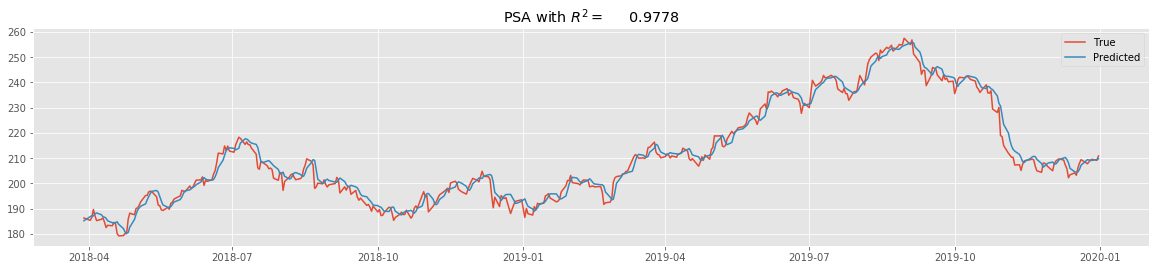

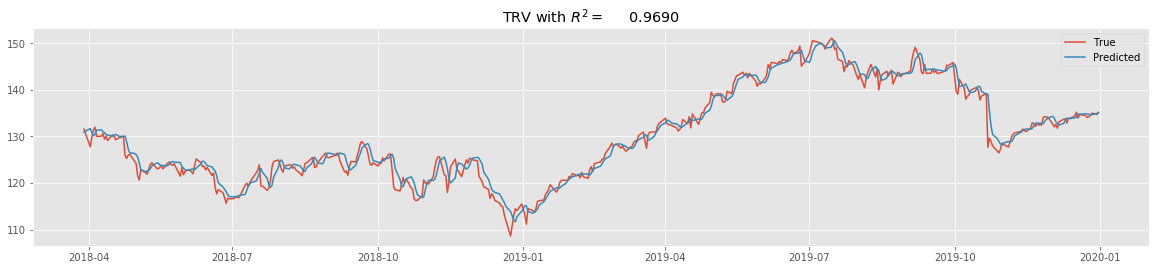

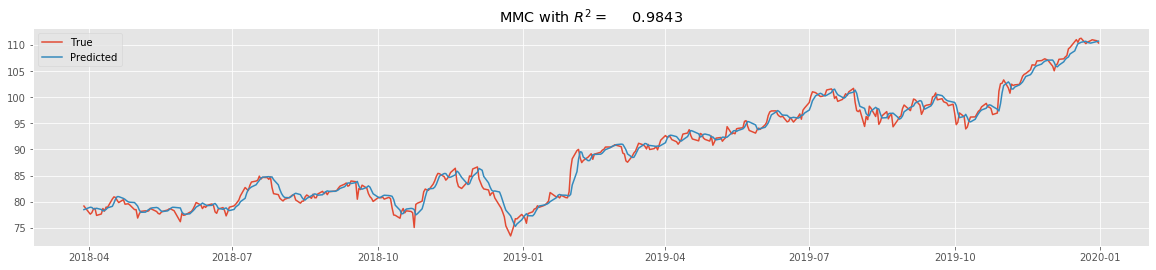

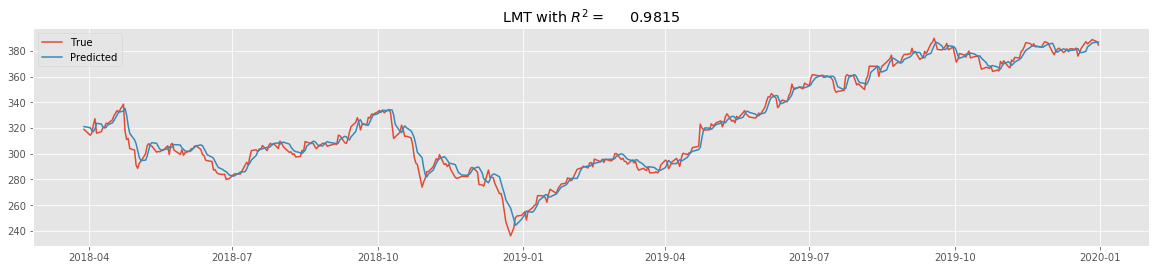

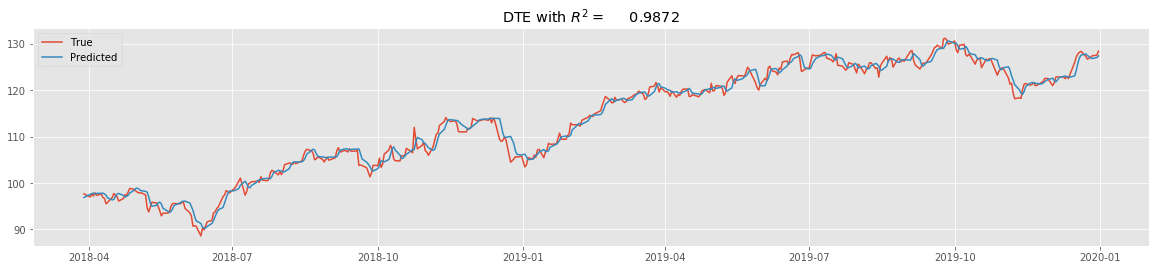

In [23]:
# Creating dictionaries for the predictions, mean squared error and R^2-values.
time_index = {}
pred_result = {}
y_true = {}
y_pred = {}
MSE = {}
r = {}

# Predicting and performing inverse transformation back to actual prices
for i in ticlist:
    time_index[i] = df_new[i]["Test"][60:].index
    y_true[i] = pd.Series(scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1)).reshape(-1), index=time_index[i])
    y_pred[i] = pd.Series(scaler[i].inverse_transform(lstm.predict(testset[i]["X"])).reshape(-1), index=time_index[i])
    MSE[i] = mean_squared_error(testset[i]["y"], lstm.predict(testset[i]["X"]))
    pred_result[i] = {}
    pred_result[i]["True"] = y_true[i]
    pred_result[i]["Pred"] = y_pred[i]
    r[i] = r2_score(pred_result[i]["True"],pred_result[i]["Pred"])

# Visualizing the results for 5 sampled stocks
for i in ticlist[:5]:  
    plt.figure(figsize=(20,4))
    plt.title("{} with $R^2 =$ {:10.4f}".format(i,r[i]))
    plt.plot(y_true[i])
    plt.plot(y_pred[i])
    plt.legend(["True", "Predicted"])

From the results, we see that the prediction could be improved by introducing a small lag. Below we add a lag of two days to the predictions to visualize this.

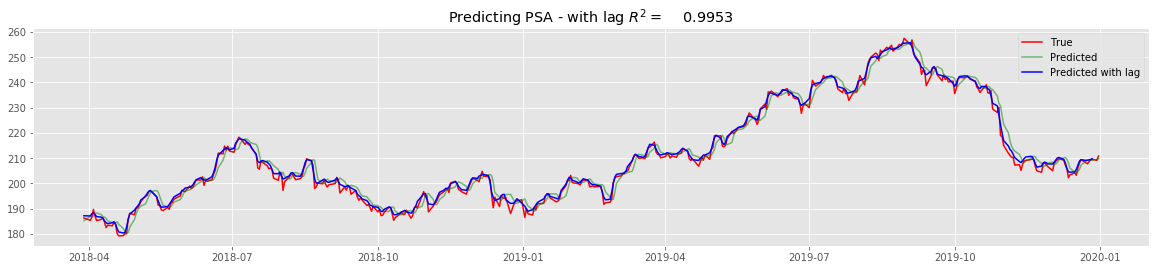

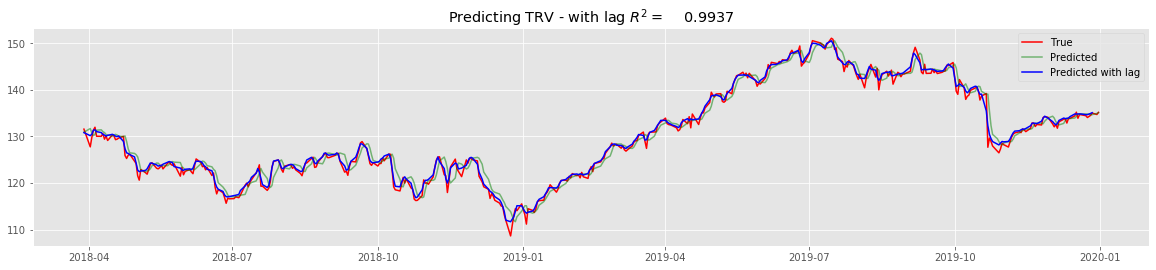

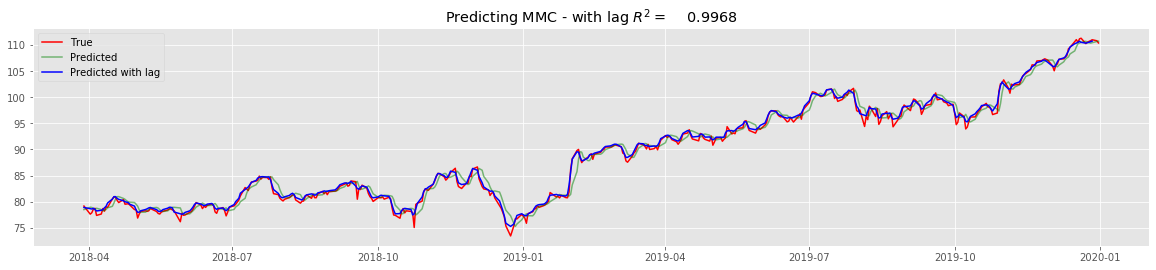

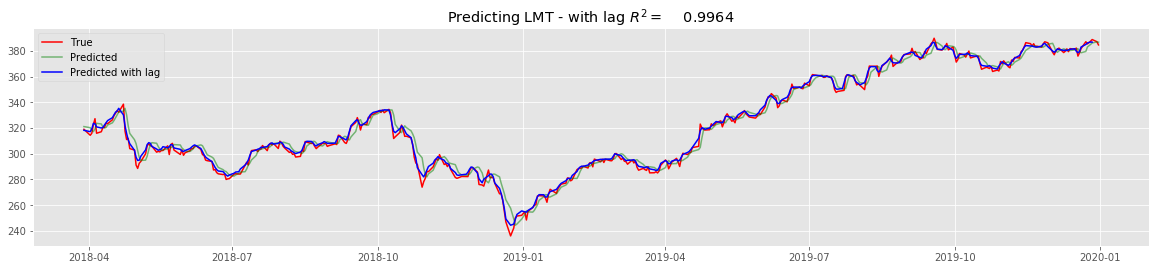

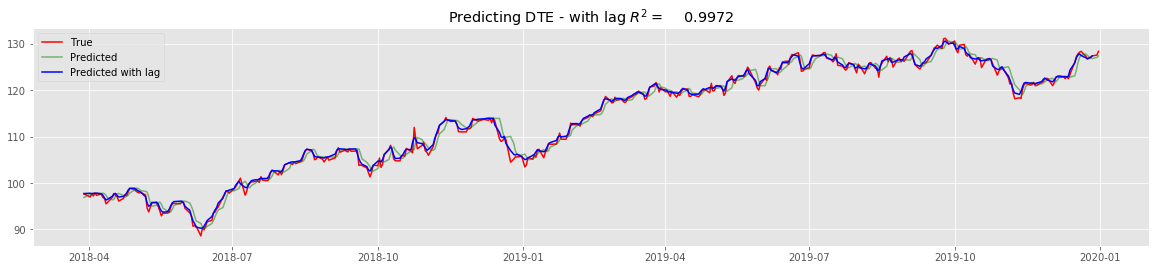

In [24]:
time_index = df_new["PSA"]["Test"][60:].index
df_pred = {}
df_true = {}
df_pred_lag = {}
r = {}
Rsquared_lag = {}
for i in ticlist:
    df_pred[i] = pd.Series(scaler[i].inverse_transform(lstm.predict(testset[i]["X"])).reshape(-1), index=time_index)
    df_true[i] = pd.Series(scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1)).reshape(-1), index=time_index)
    df_pred_lag[i] = df_pred[i].shift(-2)
    r[i] = r2_score(df_true[i],df_pred[i])
    Rsquared_lag[i] = r2_score(np.array(df_true[i][:-2]), np.array(df_pred_lag[i][:-2]))

for i in ticlist [:5]:
    plt.figure(figsize=(20,4))
    plt.title("Predicting {} - with lag $R^2=${:10.4f}".format(i, Rsquared_lag[i]))
    plt.plot(df_true[i], color = 'red')
    plt.plot(df_pred[i], color = 'green', alpha = 0.5)
    plt.plot(df_pred_lag[i], color = 'blue')
    plt.legend(["True", "Predicted", "Predicted with lag"])

## Results

Below, we show the results regarding our research question, whether the volatility and standard deviation of the percent change in trading volume are related to the goodness of fit and the mean squared error of the model. Note: we now use the $R^2$-value obtained from the model itself, i.e. without lagging the predictions. Also, the mean squared errors of the model are calculated from the normalized values.

In [31]:
# All R^2-values, MSEs, volatility and std of % change in trading volume in one DataFrame
r_square = pd.DataFrame(r.items())
r_square.columns = ['Symbols', '$R^2$']
r_square.set_index('Symbols', inplace = True)

mse = pd.DataFrame(MSE.items())
mse.columns = ['Symbols', 'MSE']
mse.set_index('Symbols', inplace = True)

results = r_square.merge(mse, how='left', left_index=True, right_index=True)
results = results.merge(p_vol, how='left', left_index=True, right_index=True)
results = results.merge(v_std, how ='left', left_index = True, right_index = True )
results.head()

,$R^2$,MSE,p_vol,v_std
Symbols,,,,
PSA,0.977757,0.001007,0.012409,0.402029
TRV,0.969012,0.001696,0.011224,0.414082
MMC,0.984328,0.000986,0.011137,0.435838
LMT,0.981509,0.001092,0.011140,0.459343
DTE,0.987154,0.000901,0.010090,0.476314


In [32]:
# Correlation coefficients of variables of interest and the goodness of fit
results.corr()['$R^2$']

$R^2$    1.000000
MSE     -0.736192
p_vol   -0.309598
v_std    0.083690
Name: $R^2$, dtype: float64

In [33]:
# Correlation coefficients of variables of interest and the mean squared error
results.corr()['MSE']

$R^2$   -0.736192
MSE      1.000000
p_vol    0.217481
v_std   -0.028872
Name: MSE, dtype: float64

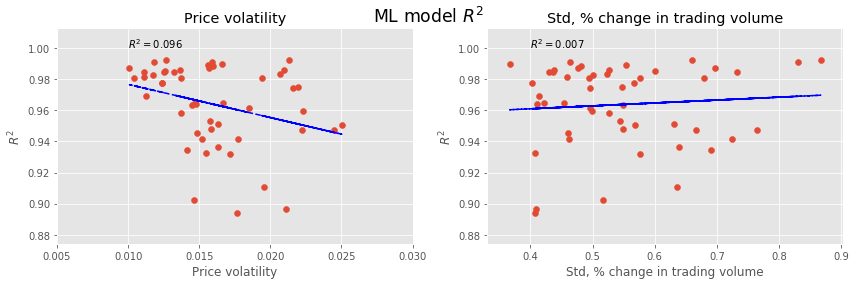

In [34]:
# Plotting the results
z1 = np.polyfit(results['p_vol'], results['$R^2$'], 1)
p1 = np.poly1d(z1)
text1 = f"\n$R^2 = {r2_score(results['$R^2$'],p1(results['p_vol'])):0.3f}$"

z2 = np.polyfit(results['v_std'], results['$R^2$'], 1)
p2 = np.poly1d(z2)
text2 = f"\n$R^2 = {r2_score(results['$R^2$'],p2(results['v_std'])):0.3f}$"

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(12,4))
fig.suptitle('ML model $R^2$', size = 'xx-large')

ax[0].scatter(results['p_vol'], results['$R^2$'])
ax[0].plot(results['p_vol'],p1(results['p_vol']),"b--")
ax[0].set_title('Price volatility')
ax[0].text(0.01, 1, text1)
ax[0].set_ylabel('$R^2$')
ax[0].set_xlabel('Price volatility')
ax[0].set_xlim(0.005, 0.03)

ax[1].scatter(results['v_std'], results['$R^2$'])
ax[1].plot(results['v_std'],p2(results['v_std']),"b--")
ax[1].set_title('Std, % change in trading volume')
ax[1].text(0.4, 1, text2)
ax[1].set_ylabel('$R^2$')
ax[1].set_xlabel('Std, % change in trading volume')

plt.tight_layout()
plt.show()

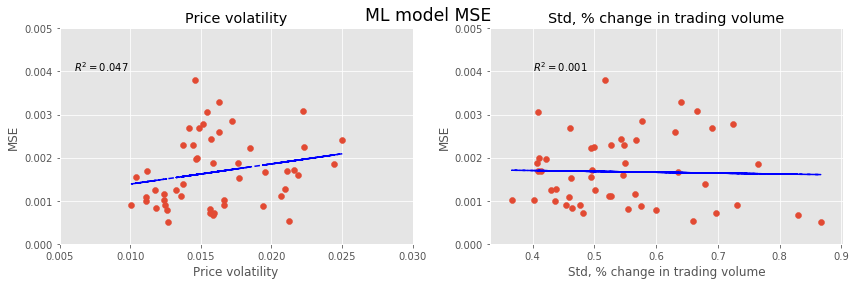

In [35]:
# Plotting the results
z3 = np.polyfit(results['p_vol'], results['MSE'], 1)
p3 = np.poly1d(z3)
text3 = f"\n$R^2 = {r2_score(results['MSE'],p3(results['p_vol'])):0.3f}$"

z4 = np.polyfit(results['v_std'], results['MSE'], 1)
p4 = np.poly1d(z4)
text4 = f"\n$R^2 = {r2_score(results['MSE'],p4(results['v_std'])):0.3f}$"

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(12,4))
fig.suptitle('ML model MSE', size = 'xx-large')

ax[0].scatter(results['p_vol'], results['MSE'])
ax[0].plot(results['p_vol'],p3(results['p_vol']),"b--")
ax[0].set_title('Price volatility')
ax[0].text(0.006, 0.004, text3)
ax[0].set_ylabel('MSE')
ax[0].set_xlabel('Price volatility')
ax[0].set_xlim(0.005, 0.03)
ax[0].set_ylim(0, 0.005)

ax[1].scatter(results['v_std'], results['MSE'])
ax[1].plot(results['v_std'],p4(results['v_std']),"b--")
ax[1].set_title('Std, % change in trading volume')
ax[1].text(0.4, 0.004, text4)
ax[1].set_ylabel('MSE')
ax[1].set_xlabel('Std, % change in trading volume')
ax[1].set_ylim(0, 0.005)

plt.tight_layout()
plt.show()

As we see from the results above, we cannot find evidence for the relationship between the variables of interest and the outcome variable. Therefore we are not able to reject any null hypothesis of no effect.

# Robustness Analysis <a class="anchor" id="ninth-bullet"></a>

In the sampling process, we take care that outliers regarding the variables of interest are not included in our sample. We believe that this makes our results more externally valid, as it makes the results more general. Also, our method of stratified sampling has resulted into improved internal validity, as the sample is representative of the population. We show this by presenting the means and standard deviations of the variables of interest in contexts of the population and sample.

Tuning the ML model by making use of the talos package improves the robustness of our results as the ML model is optimized for our set of data. However, tuning the model for each stock separately might produce the best result, but this is not feasible when considering limitations of CPU power and time constraints.

Concerning our method, we believe that correlation analysis is the most feasible. Running a multivariate regression is not possible due to the high correlation between these two independent variables.

# Discussion and conclusion <a class="anchor" id="tenth-bullet"></a>

Looking at our results, we find no evidence of a relationship between our variables of interest and the goodness of fit of an LSTM model. The analysis might be improved by tuning the model parameters for each stock in the sample individually. Due to CPU power limitations and time constraints, this was not a feasible. However, since we are not able to reject the null hypotheses, individually tuning the model might not be necessary as we believe that evidence for a relationship would have been found when using the same model parameters. In the case where evidence for a relationship were to be found, then individually tuning the model parameters would be more justified. Our results imply that LSTM models with normalized data are able to quickly learn, no matter the inherent factors of the stock price. Therefore, we believe that further research into the topic should be more directed to alternative data sources to improve the predicting ability of the model.